# =============================================================
# 1. Setup
# =============================================================

## Importing Relevant Libraries

#### General

In [1]:
import pandas as pd
import numpy as np

#### For scaling the data

In [2]:
from sklearn.preprocessing import StandardScaler, normalize

#### For clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

#### For principal component analysis

In [4]:
from sklearn.decomposition import PCA

#### For plotting

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================
# 2. Read in the data
# =============================================================

### Read in data from PVL-Delta model

In [6]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [7]:
df_pvl_delta.head()

group  SubID        LR  Outcome_Sens  Response_cons  Loss_Aver
0  young      1  0.159011      0.487522       0.686815   0.954498
1  young      2  0.064666      0.511008       1.391790   0.295529
2  young      3  0.113089      0.465141       0.918734   0.533232
3  young      4  0.089273      0.500391       0.703737   0.869859
4  young      5  0.233898      0.488053       0.897867   0.511095

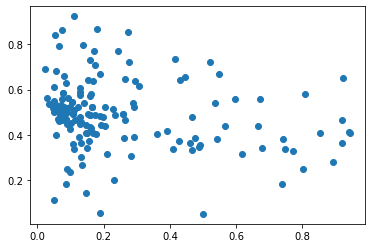

In [8]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

#### Processing
'SubID' column can be dropped as it is not used for analysis.

In [9]:
df_pvl_delta.drop(columns=['SubID'], inplace=True)

In [10]:
df_pvl_delta.head()

group        LR  Outcome_Sens  Response_cons  Loss_Aver
0  young  0.159011      0.487522       0.686815   0.954498
1  young  0.064666      0.511008       1.391790   0.295529
2  young  0.113089      0.465141       0.918734   0.533232
3  young  0.089273      0.500391       0.703737   0.869859
4  young  0.233898      0.488053       0.897867   0.511095

### Read in data from the ORL model

In [11]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [12]:
df_orl.head()

subjID        A+        A-         K     BetaF     BetaP     A+-A-
0    old  0.324444  0.068862  1.502130  2.523191 -5.547480  0.255581
1    old  0.885744  0.120145  0.012591  3.193244 -9.159800  0.765598
2    old  0.318205  0.078128  1.927309  0.615708  9.272336  0.240077
3    old  0.728192  0.106737  0.388407  2.595746 -2.239555  0.621455
4    old  0.356229  0.091987  1.810674  0.508605  9.825699  0.264241

#### Processing
'subjID' column in input file is actually the 'group' column based on its contents. Thus, rename the column as so.

In [13]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

group        A+        A-         K     BetaF     BetaP     A+-A-
0   old  0.324444  0.068862  1.502130  2.523191 -5.547480  0.255581
1   old  0.885744  0.120145  0.012591  3.193244 -9.159800  0.765598
2   old  0.318205  0.078128  1.927309  0.615708  9.272336  0.240077
3   old  0.728192  0.106737  0.388407  2.595746 -2.239555  0.621455
4   old  0.356229  0.091987  1.810674  0.508605  9.825699  0.264241

### Read in data from the VPP model

In [14]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [15]:
df_vpp.head()

group  SubID        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  \
0  young      1  0.038441  0.630402  1.207295   1.050323  -0.535035   
1  young      2  0.045673  0.630331  1.628191   0.205205  -0.133367   
2  young      3  0.045468  0.602974  1.395572   0.383055  -0.344822   
3  young      4  0.035789  0.635677  1.067831   0.823790  -0.229192   
4  young      5  0.060655  0.636276  1.802964   0.329246  -0.616020   

   Loss_Impa  Deca_Rate  RL_weight  
0  -1.913099   0.669323   0.660446  
1  -1.423580   0.427207   0.719352  
2  -1.719826   0.493249   0.688723  
3  -1.484455   0.625835   0.675971  
4  -2.561017   0.439912   0.655563

#### Processing
'SubID' column is dropped as before as it is not used for analysis.

In [16]:
df_vpp.drop(columns=['SubID'], inplace=True)
df_vpp.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young  0.038441  0.630402  1.207295   1.050323  -0.535035  -1.913099   
1  young  0.045673  0.630331  1.628191   0.205205  -0.133367  -1.423580   
2  young  0.045468  0.602974  1.395572   0.383055  -0.344822  -1.719826   
3  young  0.035789  0.635677  1.067831   0.823790  -0.229192  -1.484455   
4  young  0.060655  0.636276  1.802964   0.329246  -0.616020  -2.561017   

   Deca_Rate  RL_weight  
0   0.669323   0.660446  
1   0.427207   0.719352  
2   0.493249   0.688723  
3   0.625835   0.675971  
4   0.439912   0.655563

# =============================================================
# 3. Scale the data
# =============================================================

#### Choose which data source to use

In the paper, Lili concludes that the VPP model was the best-fitting model in terms of short-term prediction performance for the IGT task, as measured by one-step-ahead leave-one-out information criterion (LOOIC). Therefore, we will begin by analysing this dataset.

In [17]:
chosen_df = df_vpp

* The *'group'* column will not be used as a feature for the clustering analysis, so we will exclude this from the processing for now.

In [18]:
train_df = chosen_df.drop(columns=["group"])

We can describe the data in this dataframe and look at the ranges of the variables and their distributions

In [19]:
train_df.describe()

LR    Out_Sens    Res_Cons   Loss_Aver   Gain_Impa   Loss_Impa  \
count  153.000000  153.000000  153.000000  153.000000  153.000000  153.000000   
mean     0.070824    0.560575    1.329323    0.952138    0.460940   -0.720379   
std      0.064683    0.111139    0.198041    0.580621    1.185591    1.102656   
min      0.027454    0.352471    0.879707    0.193857   -2.977630   -2.912838   
25%      0.038294    0.448811    1.202790    0.528927   -0.287230   -1.634716   
50%      0.050247    0.590334    1.316736    0.760613    0.593115   -0.779120   
75%      0.078495    0.646090    1.428836    1.292569    1.419412    0.137599   
max      0.617431    0.818137    1.938694    2.698527    2.559126    1.583109   

        Deca_Rate   RL_weight  
count  153.000000  153.000000  
mean     0.406367    0.622995  
std      0.187483    0.066657  
min      0.042780    0.452978  
25%      0.256420    0.569390  
50%      0.439912    0.640917  
75%      0.565139    0.675971  
max      0.858421    0.744017

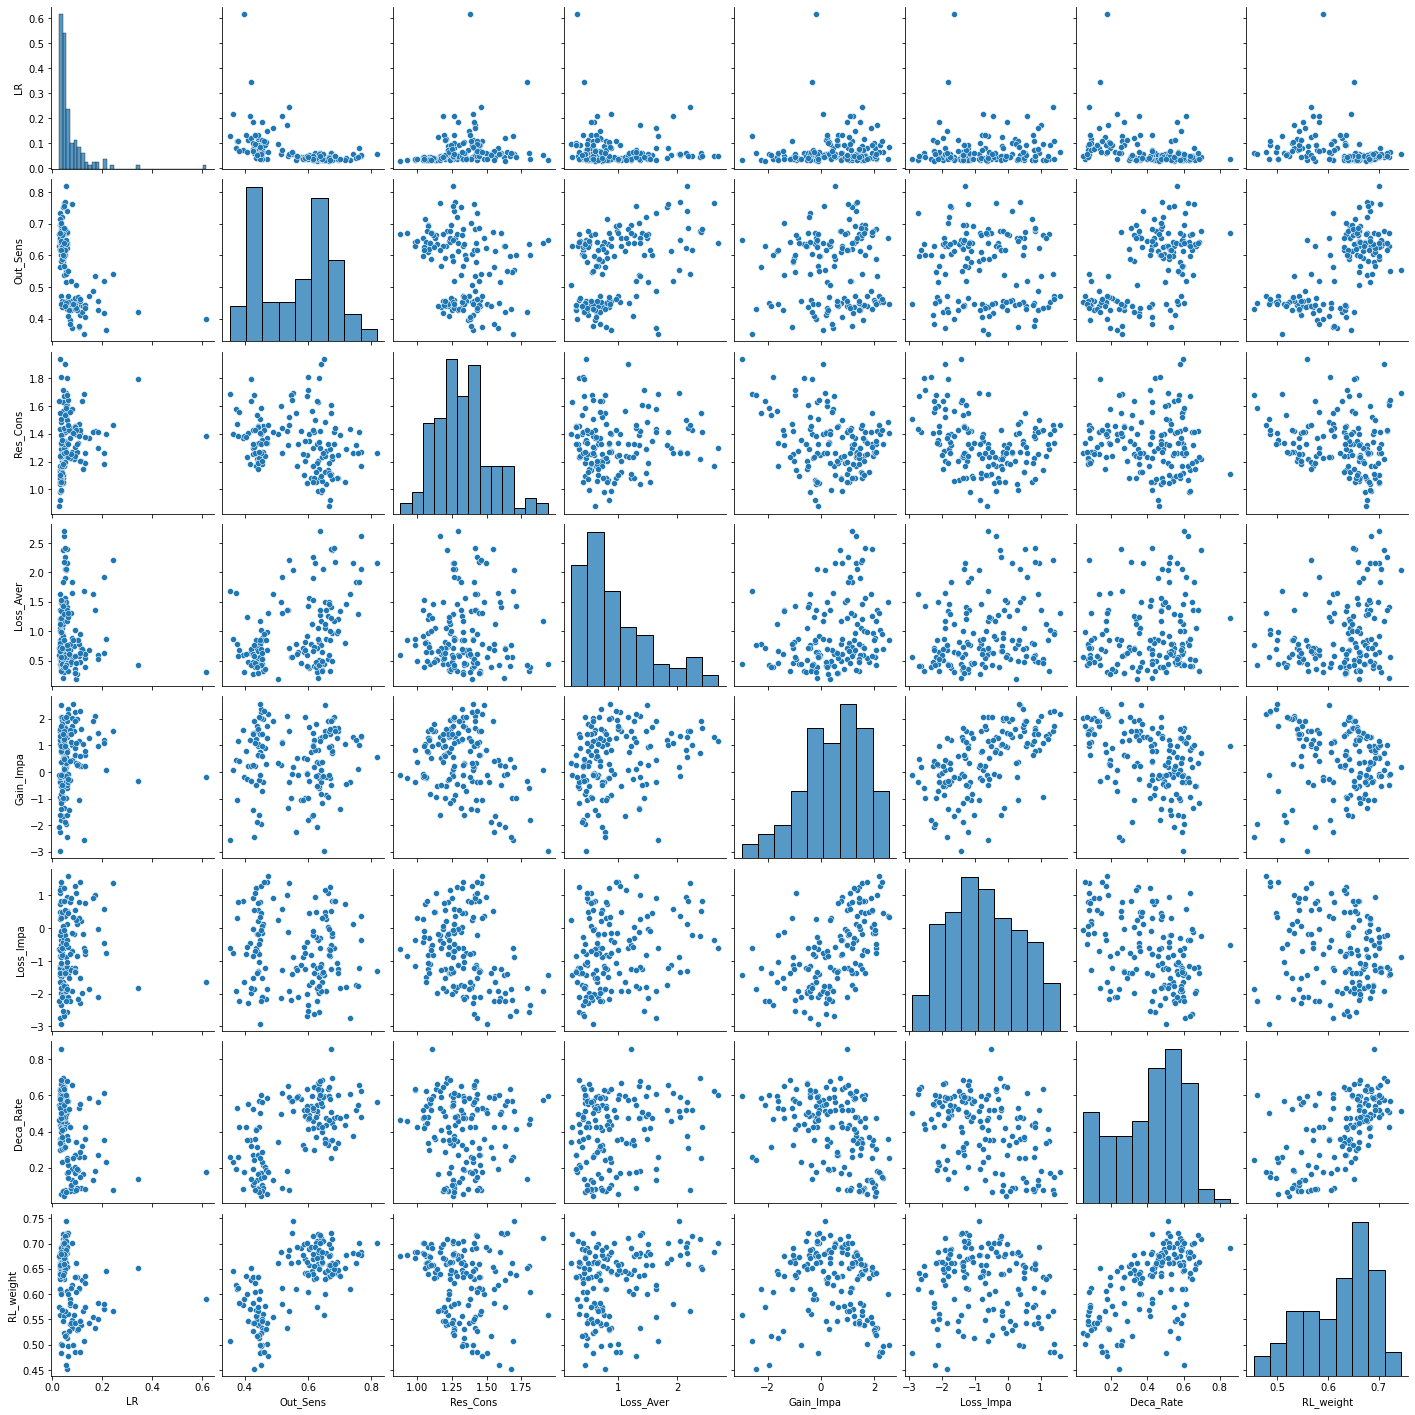

In [20]:
#Visualising the distributions of the different variables
sns.pairplot(train_df)

From the pair plot above, we can clearly see that many of the variables have either positively or negatively skewed distributions. There also appears to be many outliers in each distribution and the different parameters don't share a common scale.

To remedy this and also to ensure sound clustering analysis, we need to **scale** the dataset.

#### Scaling the features

In [21]:
# Standardising the data
standardised_train_array = StandardScaler().fit_transform(train_df)

# Normalizing the data
normalised_nd_standardised_train_array = normalize(standardised_train_array, axis=0)

# Converting the scaled array back to a DataFrame
scaled_train_df = pd.DataFrame(normalised_nd_standardised_train_array, columns=train_df.columns)

In [22]:
scaled_train_df.describe()

LR      Out_Sens      Res_Cons     Loss_Aver   Gain_Impa  \
count  1.530000e+02  1.530000e+02  1.530000e+02  1.530000e+02  153.000000   
mean  -2.902544e-18  1.161018e-17  2.031781e-17  1.451272e-18    0.000000   
std    8.111071e-02  8.111071e-02  8.111071e-02  8.111071e-02    0.081111   
min   -5.438584e-02 -1.518770e-01 -1.841472e-01 -1.059293e-01   -0.235245   
25%   -4.079214e-02 -8.156703e-02 -5.182350e-02 -5.912117e-02   -0.051185   
50%   -2.580297e-02  2.171851e-02 -5.155164e-03 -2.675543e-02    0.009043   
75%    9.618559e-03  6.240928e-02  4.075695e-02  4.755704e-02    0.065573   
max    6.854293e-01  1.879718e-01  2.495777e-01  2.439647e-01    0.143545   

          Loss_Impa     Deca_Rate     RL_weight  
count  1.530000e+02  1.530000e+02  1.530000e+02  
mean   2.902544e-18 -1.161018e-17 -2.612289e-17  
std    8.111071e-02  8.111071e-02  8.111071e-02  
min   -1.612760e-01 -1.572984e-01 -2.068814e-01  
25%   -6.725810e-02 -6.487139e-02 -6.522806e-02  
50%   -4.320979e-03  1.451265e-02  2.180811e-02  
75%    6.311234e-02  6.868974e-02  6.446273e-02  
max    1.694432e-01  1.955719e-01  1.472632e-01

#### Add the group feature back in

Since the data is now fully processed and ready for clustering, we can add the *'group'* column back in as it will be needed later on.

In [23]:
scaled_full_df = pd.concat([chosen_df["group"], scaled_train_df], axis=1)

In [24]:
scaled_full_df.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young -0.040608  0.050960 -0.049978   0.013716  -0.068138  -0.087736   
1  young -0.031540  0.050908  0.122406  -0.104344  -0.040659  -0.051727   
2  young -0.031797  0.030943  0.027133  -0.079499  -0.055125  -0.073519   
3  young -0.043933  0.054810 -0.107098  -0.017930  -0.047214  -0.056205   
4  young -0.012752  0.055247  0.193987  -0.087016  -0.073679  -0.135396   

   Deca_Rate  RL_weight  
0   0.113763   0.045572  
1   0.009016   0.117250  
2   0.037588   0.079980  
3   0.094949   0.064463  
4   0.014513   0.039631

# =============================================================
# 4. Consider the clustering algorithm and the number of clusters
# =============================================================

There are a number of clustering algorithms which we could implement. Below, we try the *KMeans* and *Spectral Clustering* algorithms and analyse how these perform on the data in question. 

To determine which algorithm is more appropriate to the dataset, we will measure their performance using the *Silhouette Coefficient*. The Silhouette Coefficient of a data point quantifies how similar a data point is to its own cluster compared to other clusters. We will use the mean Silhouette Coefficient across all data points to compare the performace of algorithms.

The **Silhouette Coefficient** for a particular data point is calculated by the below formula:

$$s = \frac{b - a}{max(a, b)}$$

Where:

 - **a** is the mean distance between a data point and all other points in the same cluster. (the mean intra-cluster distance)
 - **b** is the mean distance between a data point and all other points in the *next nearest cluster*. (the mean nearest-cluster distance)

The Silhouette score can assume values between -1 and 1. Scores closer to -1 indicate incorrect clustering whereas those nearer to +1 indicate highly dense clustering. Scores around zero are indicative of overlapping clusters. Therefore, a good indicator of what clustering algorithm to choose would be the one whose mean Silhouette Coefficient is nearest to 1.


Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53–65. doi:10.1016/0377-0427(87)90125-7.

#### Choose the number of clusters to test these algorithms on

In [25]:
num_clusters_to_iter = range(2, 11)

#### Choose the random seed number

In [26]:
random_seed_val = 127

#### Define the functions for calculating the silhouette scores of the different models

In [27]:
def get_silhouette_scores_list(scaled_train_df, model_function, num_clusters_to_itr, random_seed_val, affinity_value=None):
    
    # Initialise empty list for the Silhouette Scores for KMeans model
    s_scores = []

    # Running algorithm and calculating Silhouette Score
    for k in num_clusters_to_iter:

        # Building the clustering model
        if affinity_value:
            model = model_function(n_clusters = k, random_state = random_seed_val, affinity = affinity_value)
            
        else:
            model = model_function(n_clusters = k, random_state = random_seed_val)
        
        # Training the model and storing the predicted cluster labels
        labels = model.fit_predict(scaled_train_df)

        # Evaluating the performance and adding score to list
        s_scores.append(silhouette_score(scaled_train_df, labels))

    return s_scores

In [28]:
def analyse_silhouette_scores_to_get_optimal_cluster_number(silhouette_score_list, num_clusters_to_iter):
    
    # Analyse these results to see the optimal cluster number
    max_silhouette_score = max(silhouette_score_list)
    index_max_score = silhouette_score_list.index(max_silhouette_score)

    print("The maximum Silhouette Score was", max_silhouette_score)
    print("This score is achieved by running", num_clusters_to_iter[index_max_score], "clusters")

    # plot the silhoutte scores against the cluster numbers
    plt.plot(num_clusters_to_iter, silhouette_score_list, 'bx-')
    plt.xlabel('# Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette scores for the model accross a different number of clusters')
    plt.show()

    # Output a table of the score for each cluster
    cluster_nd_score_df = pd.DataFrame(silhouette_score_list, index=num_clusters_to_iter).rename(columns={0: "Silhouette Score"})
    cluster_nd_score_df.index.name = "# Clusters"
    
    return cluster_nd_score_df.T

## Silhouette Scores for the KMeans Algorithm

Below the KMeans algorithm is executed with various different numbers of clusters (from 2 clusters to 10). The mean Silhouette Coefficient (or more simply, the *Silhouette Score*) for the clusters produced is calculated for each execution of the algorithm. These scores are plotted below.

#### Use K-Means to calculate the Silhouette Score for 2-10 clusters

In [29]:
s_scores_km = get_silhouette_scores_list(scaled_train_df, KMeans, num_clusters_to_iter, random_seed_val)

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.2951295885819213
This score is achieved by running 2 clusters


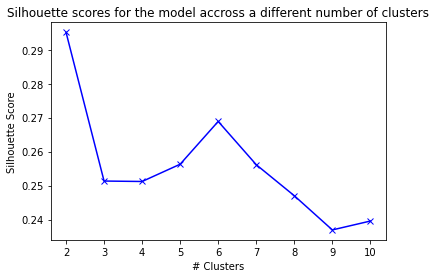

# Clusters             2         3         4       5         6        7   \
Silhouette Score  0.29513  0.251348  0.251219  0.2563  0.268886  0.25616   

# Clusters              8         9         10  
Silhouette Score  0.247031  0.236969  0.239581

In [30]:
cluster_nd_score_km_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_km, num_clusters_to_iter)
cluster_nd_score_km_df

## Silhouette Scores for Spectral Clustering Algorithm

In order to explore more options for clustering, we are going to test the performance of two different implementations of the Spectral Clustering algorithm. One implementation constructs the *affinity matrix* using a radial basis function (RBF) kernel (aka Gaussian kernel) while the other constructs this matrix by computing a graph of nearest neighbors.

### Spectral Clustering with *affinity='rbf'*

#### Use Spectral Clustering to calculate the Silhouette Score for 2-10 clusters

In [31]:
s_scores_rbf = get_silhouette_scores_list(scaled_train_df, SpectralClustering, num_clusters_to_iter, random_seed_val, 'rbf')

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.2951295885819213
This score is achieved by running 2 clusters


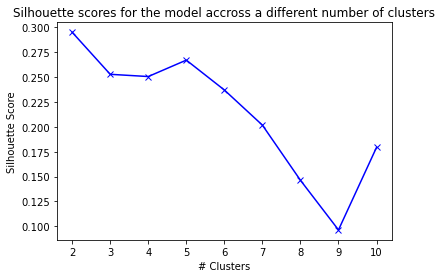

# Clusters             2         3        4         5         6         7   \
Silhouette Score  0.29513  0.252844  0.25059  0.267099  0.237073  0.201738   

# Clusters              8         9         10  
Silhouette Score  0.146303  0.096382  0.179345

In [32]:
cluster_nd_score_rbf_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_rbf, num_clusters_to_iter)
cluster_nd_score_rbf_df

### Spectral Clustering with *affinity='nearest_neighbors'*

#### Use Spectral Clustering to calculate the Silhouette Score for 2-10 clusters

In [33]:
s_scores_nn = get_silhouette_scores_list(scaled_train_df, SpectralClustering, num_clusters_to_iter, random_seed_val, 'nearest_neighbors')

#### Analyse these scores and output & plot the score

The maximum Silhouette Score was 0.2951295885819213
This score is achieved by running 2 clusters


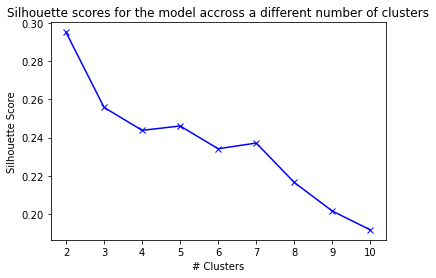

# Clusters             2         3         4         5         6         7   \
Silhouette Score  0.29513  0.255765  0.243764  0.246033  0.234108  0.237116   

# Clusters              8         9         10  
Silhouette Score  0.216459  0.201482  0.191615

In [34]:
cluster_nd_score_nn_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_nn, num_clusters_to_iter)
cluster_nd_score_nn_df

As we can see from the above results, running these clustering algorithms on this data using **two clusters** produces the best Silhouette Scores for all three algorithms.

One reason we can see why this might be the case is that the sample of data subjects can be segmented into two groups as we saw at the start; *'young'* and *'old'* and these two clusters could just be encapsulating these two groups.
To test this, we will attempt to visualise these clusters.

From the above ouputs, we can determine that Kmeans and Spectral Clustering using the nearest_neighbour affinity get the same sillhouette score for two clusters, while Spectral clustering using the rbf affinity lags a little bit behind on its sillhouette score for two clusters.

As a result, we will test our hypothesis using the Spectral Clustering algorithm to create two clusters, with 'nearest neighbour' being used to construct the affinity matrix.

#### Choose the number of clusters to use

In [35]:
num_clusters = 2

# =============================================================
# 5. Cluster the data using 2 clusters
# =============================================================

#### Build the 'rbf' spectral clustering model with these 2 clusters

In [36]:
spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='rbf', random_state=random_seed_val)

#### Training the model and storing predicted cluster labels

In [37]:
cluster_labels_array = spectral_model.fit_predict(scaled_train_df)

#### Turn this array to a dataframe so it can be concatonated with the rest of the data

In [38]:
cluster_labels_df = pd.DataFrame(cluster_labels_array, columns=["Cluster"])

In [39]:
cluster_labels_df.head()

Cluster
0        0
1        0
2        0
3        0
4        0

#### Add a new column to the original data with the cluster each row is in

In [40]:
full_df_nd_cluster = pd.concat([chosen_df, cluster_labels_df], axis=1)

In [41]:
full_df_nd_cluster.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young  0.038441  0.630402  1.207295   1.050323  -0.535035  -1.913099   
1  young  0.045673  0.630331  1.628191   0.205205  -0.133367  -1.423580   
2  young  0.045468  0.602974  1.395572   0.383055  -0.344822  -1.719826   
3  young  0.035789  0.635677  1.067831   0.823790  -0.229192  -1.484455   
4  young  0.060655  0.636276  1.802964   0.329246  -0.616020  -2.561017   

   Deca_Rate  RL_weight  Cluster  
0   0.669323   0.660446        0  
1   0.427207   0.719352        0  
2   0.493249   0.688723        0  
3   0.625835   0.675971        0  
4   0.439912   0.655563        0

Now that we have clustered this data based on the parameters, we want to verify our hypothesis that these 2 clusters will just contain the 'Young' and 'Old' groups exclusively.

We want to analyse these clusters to see how the 'Old' and 'Young' fall into these clusters and test this.

# =============================================================
# 6. Analyse these 2 clusters
# =============================================================

#### Create function to see how the young and old people are distributed within each cluster

In [42]:
def see_how_the_young_and_old_fall_into_the_clusters(input_df):
    
    # copy the dataframe so that we arent overwriting the input dataframe
    df = input_df.copy()
    
    # Create a dataframe showing how many people fell into each cluster
    all_cluster_df = pd.DataFrame(df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})
    
    # Change 'young' to 1 and 'old' to np.nan in the grou column
    df["group"] = df["group"].replace('old', np.nan).replace('young', 1)
    
    # Create a dataframe showing how many young people fell into each cluster
    young_cluster_df = pd.DataFrame(df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})
    
    # Create a dataframe showing how many old people fell into each cluster
    old_cluster_df = pd.DataFrame(df["group"].isnull().groupby(df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})
    
    # Output how many 'young' and 'old' people fell into each cluster
    return pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")

#### Check the distribution of young and old people among the 2 clusters

In [43]:
see_how_the_young_and_old_fall_into_the_clusters(full_df_nd_cluster)

All  Young  Old
Cluster                 
0         90     90    0
1         63      0   63

As you can see from the above table, our hypthesis was correct and the algorithm clustered the individuals into their respective groups of young and old.

While this test did not provide us with any more information than we already had, we felt it was vital to not make any assumptions but to verify everything before we act.
So even though from the analysis using the 'Silhouette Score' we identified that two clusters maximised this score, as we hypothesised this is because of how distinct the two groups of individuals are when it comes to decision making. As a result, we have not gained much aditional information about the data by having 2 clusters so we must experiment with a different number.

# =============================================================
# 7. Re-consider the clustering algorithms and the number of clusters (excluding cluster 2)
# =============================================================

So we have experimented using two clusters and have decided that this does not provide us with enough aditional information to satisfy our analysis.


#### Create function to output the silhoette scores excluding cluster 2

In [44]:
def take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_df):
    
    # remove cluster 2 from this dataframe
    cluster_nd_score_df_no_2 = cluster_nd_score_df.drop(columns=[2], axis=1)

    # get the silhouette scores and cluster number
    s_scores_without_2 = list(cluster_nd_score_df_no_2.iloc[0, :])
    num_clusters_to_iter_without_2 = cluster_nd_score_df_no_2.columns

    # analyse these scores
    return analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_without_2, num_clusters_to_iter_without_2)

## Silhouette Scores for the KMeans Algorithm (excluding cluster 2)

The maximum Silhouette Score was 0.26888600929104295
This score is achieved by running 6 clusters


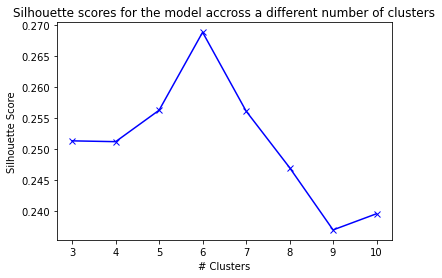

# Clusters              3         4       5         6        7         8   \
Silhouette Score  0.251348  0.251219  0.2563  0.268886  0.25616  0.247031   

# Clusters              9         10  
Silhouette Score  0.236969  0.239581

In [45]:
take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_km_df)

## Silhouette Scores for Spectral Clustering Algorithm (excluding cluster 2)

### Spectral Clustering with *affinity='rbf'* (excluding cluster 2)

The maximum Silhouette Score was 0.26709917646414355
This score is achieved by running 5 clusters


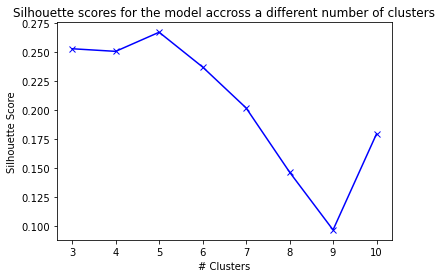

# Clusters              3        4         5         6         7         8   \
Silhouette Score  0.252844  0.25059  0.267099  0.237073  0.201738  0.146303   

# Clusters              9         10  
Silhouette Score  0.096382  0.179345

In [46]:
take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_rbf_df)

### Spectral Clustering with *affinity='nearest_neighbors'* (excluding cluster 2)

The maximum Silhouette Score was 0.25576500302229266
This score is achieved by running 3 clusters


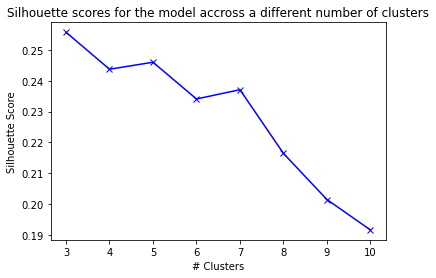

# Clusters              3         4         5         6         7         8   \
Silhouette Score  0.255765  0.243764  0.246033  0.234108  0.237116  0.216459   

# Clusters              9         10  
Silhouette Score  0.201482  0.191615

In [47]:
take_in_a_dataframe_of_an_algorithms_silhouette_scores_and_output_analysis_excluding_cluster_2(cluster_nd_score_nn_df)

Based on these result it is clear that the next best maximum silhouette score comes from the spectral clustering algorithm with affinity = 'rbf' as when we exclude 2 clusters from this analysis, the maximum silhouette score is nearly 0.27 which is higher than the others. This maximum number corrosponds to when the algorithm uses 5 clusters on the data.

As a result of this, we propose to analyse the data using the spectral clustering algorithm with affinity = 'rbf' and using 5 clusters to see how the individuals fall into these clusters.

When we used 2 clusters last time, we didn't get much added information as the individuals ended up just being clustered into their respective groups, whereas when we use 5, we expect there to be sub-clusters within these different groups that will act to detect more specific groups of people who have more dissimilar ways of making decisions.

## Further verification of cluster number using Kmeans elbow curve

#### Use K-means to determine the accuracy of clustering using 1-10 clusters

In [48]:
distortions = []
num_clusters_to_iter = range(2,11)
for k in num_clusters_to_iter:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_train_df)
    kmeanModel.fit(scaled_train_df)
    distortions.append(sum(np.min(cdist(scaled_train_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_train_df.shape[0])

#### Plot the elbow curve of the distortion that each cluster number gives

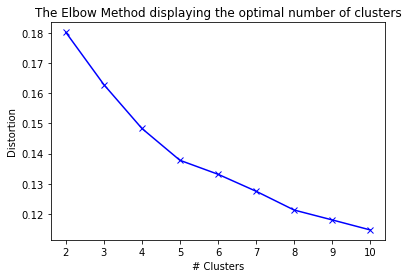

In [49]:
plt.plot(num_clusters_to_iter, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method displaying the optimal number of clusters')
plt.show()

#### Re-choose the number of clusters

In [50]:
num_cluster_second_time = 6

# =============================================================
# 8. Re-cluster the data using 5 clusters
# =============================================================

#### Building the Spectral Clustering model and clustering the data

In [51]:
kmeans_model = KMeans(n_clusters=num_cluster_second_time, random_state=random_seed_val)

#### Training the model and storing predicted cluster labels

In [52]:
second_cluster_labels_array = kmeans_model.fit_predict(scaled_train_df)

#### Get the centroids of these clusters

In [53]:
centroids = KMeans(n_clusters=6).fit(scaled_train_df).cluster_centers_

In [54]:
centroids_df = pd.DataFrame(centroids, columns=scaled_train_df.columns)

In [55]:
centroids_df

LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  Deca_Rate  \
0 -0.013246  0.082324  0.009892   0.157912   0.048098   0.038310   0.045116   
1 -0.032471  0.042616  0.059983  -0.019006  -0.078764  -0.077391   0.061948   
2 -0.042458  0.063321 -0.086944  -0.016048   0.019688   0.020637   0.035052   
3  0.029271 -0.094839  0.035598  -0.044714  -0.047915  -0.048742  -0.017808   
4  0.515193 -0.110436  0.105472  -0.082967  -0.048957  -0.074280  -0.108182   
5  0.034214 -0.079584 -0.008504  -0.014698   0.079838   0.085922  -0.115248   

   RL_weight  
0   0.066029  
1   0.047959  
2   0.050017  
3  -0.066402  
4  -0.002396  
5  -0.092626

#### Turn this array to a dataframe so it can be concatonated with the rest of the data

In [56]:
second_cluster_labels_df = pd.DataFrame(second_cluster_labels_array, columns=['Cluster'])

In [57]:
second_cluster_labels_df.head()

Cluster
0        0
1        0
2        0
3        2
4        0

In order to visualise these clusters, we will need to reduce the dimensionality of the original Dataframe so that we can represent each data point in a two dimensional space. This can be achieved by performing **Principal Component Analysis** on the data. This is done below.

# =============================================================

# 9. Principal Component Analysis

# =============================================================

There are eight parameters in this model so principal component analysis is performed below to encapsulate this information into **three principal component axes**.

#### Add the centroid data to the scaled data

In [58]:
individuals_nd_centroids_df = pd.concat([scaled_train_df, centroids_df], axis=0)

#### Inspect dataframe which PCA is being performed on

In [59]:
individuals_nd_centroids_df.head()

LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  Deca_Rate  \
0 -0.040608  0.050960 -0.049978   0.013716  -0.068138  -0.087736   0.113763   
1 -0.031540  0.050908  0.122406  -0.104344  -0.040659  -0.051727   0.009016   
2 -0.031797  0.030943  0.027133  -0.079499  -0.055125  -0.073519   0.037588   
3 -0.043933  0.054810 -0.107098  -0.017930  -0.047214  -0.056205   0.094949   
4 -0.012752  0.055247  0.193987  -0.087016  -0.073679  -0.135396   0.014513   

   RL_weight  
0   0.045572  
1   0.117250  
2   0.079980  
3   0.064463  
4   0.039631

#### Use PCA to project the data to 3 dimensions

In [60]:
# set the number of components
pca = PCA(n_components=3)

# create an array transforming the daa into these 3 components
principal_components_array = pca.fit_transform(individuals_nd_centroids_df)

# turn this array to a dataframe
principal_components_df = pd.DataFrame(data = principal_components_array, columns = ['PC1', 'PC2', 'PC3'])

In [61]:
principal_components_df.head()

PC1       PC2       PC3
0 -0.156083  0.069454 -0.029499
1 -0.076820  0.118750  0.000347
2 -0.086346  0.103445 -0.041181
3 -0.150312  0.021432 -0.074575
4 -0.052560  0.213905  0.040565

#### Look at how much variance these 3 axes explain

In [62]:
print(pca.explained_variance_ratio_)

print("\nWhen projecting the data onto the three principal componets, approximately {}% of the variance in the original data is retained".format(round(pca.explained_variance_ratio_.sum(), 3)*100))

[0.35174788 0.24935726 0.13494294]

When projecting the data onto the three principal componets, approximately 73.6% of the variance in the original data is retained


#### Remove the centroid data from this table

In [63]:
individual_pca_df = principal_components_df.iloc[:-6, :]

pca_centroid_df = principal_components_df.iloc[-6:, :]

#### Add these principal component columns and the cluster labels to the rest of the data

In [64]:
final_full_scaled_df = pd.concat([scaled_full_df, individual_pca_df, second_cluster_labels_df], axis = 1)

In [65]:
final_full_scaled_df.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young -0.040608  0.050960 -0.049978   0.013716  -0.068138  -0.087736   
1  young -0.031540  0.050908  0.122406  -0.104344  -0.040659  -0.051727   
2  young -0.031797  0.030943  0.027133  -0.079499  -0.055125  -0.073519   
3  young -0.043933  0.054810 -0.107098  -0.017930  -0.047214  -0.056205   
4  young -0.012752  0.055247  0.193987  -0.087016  -0.073679  -0.135396   

   Deca_Rate  RL_weight       PC1       PC2       PC3  Cluster  
0   0.113763   0.045572 -0.156083  0.069454 -0.029499        0  
1   0.009016   0.117250 -0.076820  0.118750  0.000347        0  
2   0.037588   0.079980 -0.086346  0.103445 -0.041181        0  
3   0.094949   0.064463 -0.150312  0.021432 -0.074575        2  
4   0.014513   0.039631 -0.052560  0.213905  0.040565        0

# =============================================================

# 10. Plot the 5 clusters using the PCA axes

# =============================================================

## Plot the clusters

#### Choose the columns to plot

In [66]:
pc1 = final_full_scaled_df['PC1']
pc2 = final_full_scaled_df['PC2']
pc3 = final_full_scaled_df['PC3']
group = final_full_scaled_df['group']
cluster = final_full_scaled_df['Cluster']
all_rows = pd.Series(["All"] * len(final_full_scaled_df))

#### Check the minimum and maximum values across all axes

In [67]:
print("pc1", min(pc1), max(pc1))
print("pc2", min(pc2), max(pc2))
print("pc3", min(pc3), max(pc3))

pc1 -0.23161416472781887 0.4039099938603223
pc2 -0.18326834603179137 0.2872630705226934
pc3 -0.13623633489329476 0.2997714643142262


#### Create function to visualise 3D projection

In [68]:
def plot_3d_principal_component_points(targets, colours, column_to_colour_cluster_with, pca_centroid_df=pd.DataFrame()):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # title the axes
    ax.set_xlabel('Principal Component 1', fontsize = 10)
    ax.set_ylabel('Principal Component 2', fontsize = 10)
    ax.set_zlabel('Principal Component 3', fontsize = 10)

    # set limits on the plot
    ax.set_xlim([-0.23, 0.4])
    ax.set_ylim([-0.2, 0.3])
    ax.set_zlim([-0.15, 0.3])
    ax.set_title('Visualising Clusters Produced by the Spectral Clustering Algorithm', fontsize = 15)

    # plot the points
    for target, colour in zip(targets, colours):
        ax.scatter(pc1.loc[column_to_colour_cluster_with == target], pc2.loc[column_to_colour_cluster_with == target], pc3.loc[column_to_colour_cluster_with == target], c=colour, s=100, marker='o', edgecolors='grey')
    
    if not pca_centroid_df.empty:
        ax.scatter(pca_centroid_df['PC1'], pca_centroid_df['PC2'], pca_centroid_df['PC3'], c='black', s=100, marker='X')
        
    ax.legend(targets)
    plt.show()

#### Plot the original data

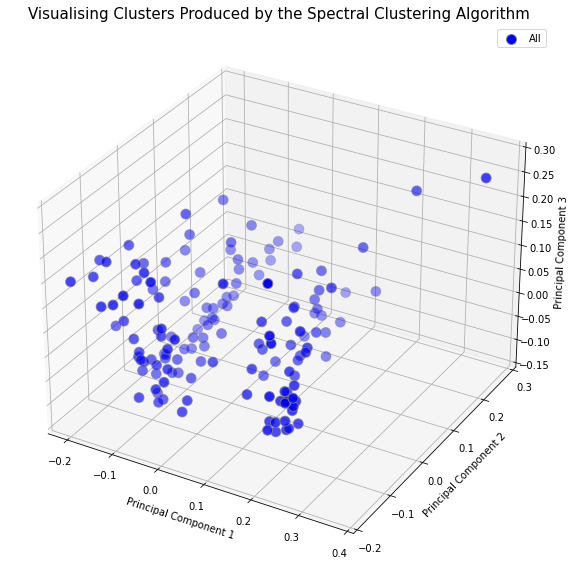

In [69]:
targets = ["All"]
colours = ['blue']

plot_3d_principal_component_points(targets, colours, all_rows)

#### Plot the data colouring the different clusters

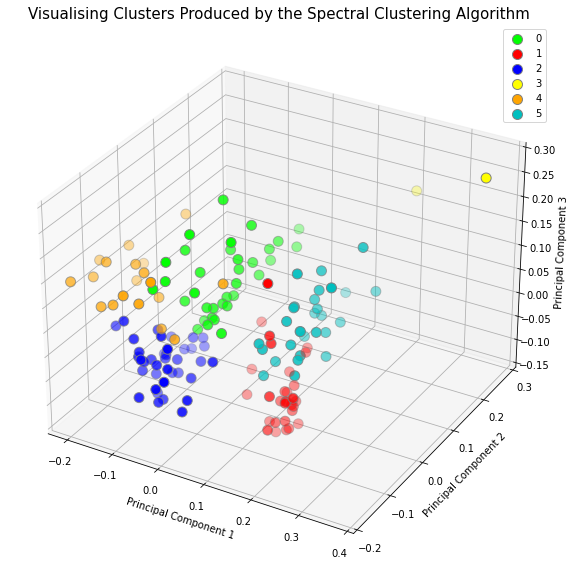

In [70]:
targets = [0, 1, 2, 3, 4, 5]
colours = ['lime', 'red', 'blue', 'yellow', 'orange', 'c']

plot_3d_principal_component_points(targets, colours, cluster)

#### Plot the data colouring the different clusters & plotting their centroids

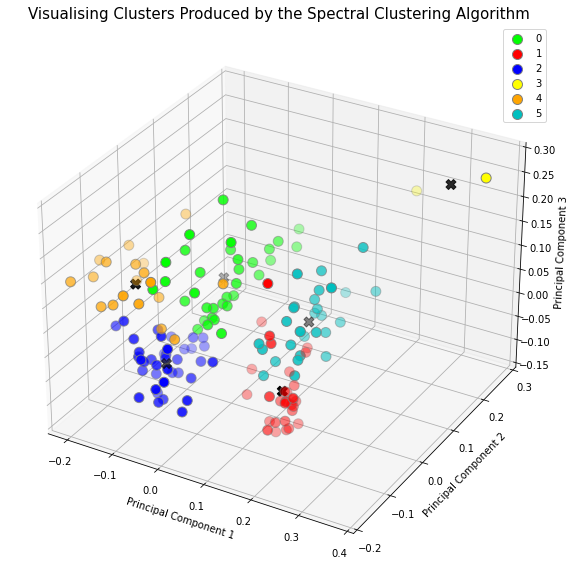

In [71]:
targets = [0, 1, 2, 3, 4, 5]
colours = ['lime', 'red', 'blue', 'yellow', 'orange', 'c']

plot_3d_principal_component_points(targets, colours, cluster, pca_centroid_df)

#### Plot the data colouring the different groups

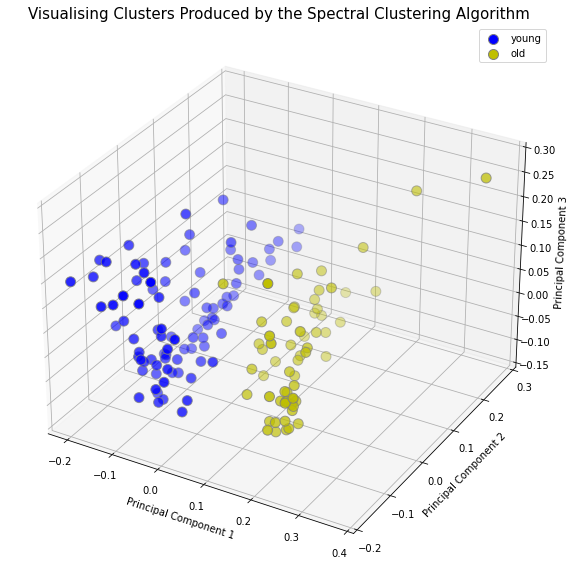

In [72]:
targets = ['young', 'old']
colours = ['b', 'y']

plot_3d_principal_component_points(targets, colours, group)

# =============================================================

# 11. Analyse these 5 clusters

# =============================================================

## a.) See how the 'Old' and 'Young' fall into these clusters

In [73]:
see_how_the_young_and_old_fall_into_the_clusters(final_full_scaled_df)

All  Young  Old
Cluster                 
0         34     34    0
1         31      0   31
2         38     38    0
3          2      0    2
4         19     18    1
5         29      0   29

## b.) Characterising the clusters based on their different *cognitive attributes*
As Lili states in the paper, a subject's performance on the IGT can be interpreted as a *synthesis of several different underlying psychological processes* [Insert Reference]. As such, the parameters of the VPP model can be treated as neuro-psychologically interpretable variables. Some details on the semantics of each variable is given below:

 * **LR** $ \Leftrightarrow $ **Learning Rate**: Quantifies the rate at which the subject learns through experience.
 * **Out_Sens** $ \Leftrightarrow $ **Outcome Sensitivity**: Accounts for the effects of win frequency. Subjects with a value less than 1 prefer decks with high win frequency over decks with the same long-term rewards but much less win frequency.
 * **Res_Cons** $ \Leftrightarrow $ **Response Consistency**: Quantifies the consistency of the subjects choices.
 * **Loss_Aver** $ \Leftrightarrow $ **Loss Aversion**: Responsible for the subjects sensitivity to loss relative to gains.
 * **Gain_Impa** $ \Leftrightarrow $ **Gain Impact**: Quantifies the impact of gain on the perseverance behaviour of the subject.
 * **Loss_Impa** $ \Leftrightarrow $ **Loss Impact**: Quantifies the impact of loss on the perseverance behaviour of the subject.
 * **Deca_Rate** $ \Leftrightarrow $ **Decay Rate**: The decay parameter which controls how quickly decision makers forget their past deck choices.
 * **RL_weight** $ \Leftrightarrow $ **Reinforcement Learning Weight**: Assumes values between 0 and 1. A low value indicates that the subject would rely less on reinforcement learning but more on the perseverance heuristic [Reference]. Whereas, a high value indicates the converse.
 
Based on these parameters, we can examine each cluster and characterise the decision-making tendencies of the subjects in that cluster. To do this, we need the original dataset before it was standardised; we append the cluster labels to this original DataFrame below.

In [74]:
df_final = pd.concat([chosen_df, second_cluster_labels_df], axis=1)
df_final.head()

group        LR  Out_Sens  Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
0  young  0.038441  0.630402  1.207295   1.050323  -0.535035  -1.913099   
1  young  0.045673  0.630331  1.628191   0.205205  -0.133367  -1.423580   
2  young  0.045468  0.602974  1.395572   0.383055  -0.344822  -1.719826   
3  young  0.035789  0.635677  1.067831   0.823790  -0.229192  -1.484455   
4  young  0.060655  0.636276  1.802964   0.329246  -0.616020  -2.561017   

   Deca_Rate  RL_weight  Cluster  
0   0.669323   0.660446        0  
1   0.427207   0.719352        0  
2   0.493249   0.688723        0  
3   0.625835   0.675971        2  
4   0.439912   0.655563        0

#### Create functions to help analyse parameters

The below functions will be useful for this piece of analysis. The first extracts the subjects from a specified cluster and provides a breakdown of the distribution of their parameters. While the second plots the distributions of each variable in a cluster.

In [75]:
def analyse_cluster_params(df, cluster_label):
    cluster_df = df[df['Cluster'] == cluster_label].iloc[:, 1:-1]
    return cluster_df.describe()

In [76]:
def plot_cluster_params(df, cluster_label, ax):
    cluster_df = df[df['Cluster'] == cluster_label].iloc[:, 1:-1]
    for i, col in enumerate(cluster_df.columns):
        sns.histplot(data=cluster_df, x=col, kde=True, ax=axes[i])
    plt.show()

### Analsye Cluster 0

In [77]:
df_final_c0 = df_final[df_final['Cluster'] == 0].iloc[:, 1:-1]
df_final_c0.describe()

LR   Out_Sens   Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
count  34.000000  34.000000  34.000000  34.000000  34.000000  34.000000   
mean    0.044930   0.618968   1.475779   0.816085  -0.690345  -1.772467   
std     0.009610   0.055746   0.214690   0.433378   0.811496   0.576240   
min     0.027454   0.514825   1.144924   0.205205  -2.977630  -2.750683   
25%     0.037697   0.584808   1.296579   0.431615  -1.058930  -2.132671   
50%     0.045361   0.623354   1.422935   0.718892  -0.534546  -1.810896   
75%     0.051248   0.640286   1.632197   1.262242  -0.086096  -1.372874   
max     0.064735   0.757811   1.938694   1.634251   0.501664  -0.111529   

       Deca_Rate  RL_weight  
count  34.000000  34.000000  
mean    0.549555   0.662408  
std     0.086004   0.039829  
min     0.327646   0.559136  
25%     0.488916   0.641616  
50%     0.571731   0.663733  
75%     0.598075   0.687539  
max     0.685362   0.721415

In [78]:
analyse_cluster_params(df_final, 0)

LR   Out_Sens   Res_Cons  Loss_Aver  Gain_Impa  Loss_Impa  \
count  34.000000  34.000000  34.000000  34.000000  34.000000  34.000000   
mean    0.044930   0.618968   1.475779   0.816085  -0.690345  -1.772467   
std     0.009610   0.055746   0.214690   0.433378   0.811496   0.576240   
min     0.027454   0.514825   1.144924   0.205205  -2.977630  -2.750683   
25%     0.037697   0.584808   1.296579   0.431615  -1.058930  -2.132671   
50%     0.045361   0.623354   1.422935   0.718892  -0.534546  -1.810896   
75%     0.051248   0.640286   1.632197   1.262242  -0.086096  -1.372874   
max     0.064735   0.757811   1.938694   1.634251   0.501664  -0.111529   

       Deca_Rate  RL_weight  
count  34.000000  34.000000  
mean    0.549555   0.662408  
std     0.086004   0.039829  
min     0.327646   0.559136  
25%     0.488916   0.641616  
50%     0.571731   0.663733  
75%     0.598075   0.687539  
max     0.685362   0.721415

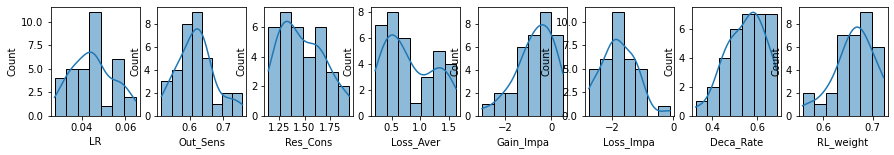

In [79]:
fig, axes = plt.subplots(ncols=8, figsize=(15,2))

plot_cluster_params(df_final, 0, axes)